<a href="https://colab.research.google.com/github/androbaza/smlm-seg/blob/main/SMLM_image_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

True

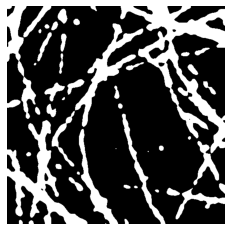

In [19]:
def create_mask(img, mask_value=1):
    return img < 0

# TODO: Otsu's Binarization

img = cv2.imread('/content/12.png', 0)
blur = cv2.GaussianBlur(img,(27,27),0)
ret, fig = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.axis('off')
plt.imshow(fig, cmap='gray')
# plt.savefig("1mask.png", bbox_inches='tight')
cv2.imwrite("11_mask_gau7_otsu.png", fig)
# plt.show()

In [1]:
!git clone https://github.com/imodpasteur/ANNA-PALM
%cd ANNA-PALM

Cloning into 'ANNA-PALM'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 320 (delta 4), reused 0 (delta 0), pack-reused 308
Receiving objects: 100% (320/320), 622.42 KiB | 3.11 MiB/s, done.
Resolving deltas: 100% (179/179), done.
/content/ANNA-PALM


In [3]:
%tensorflow_version 1.x

In [4]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
pip install -r requirements.txt

In [6]:
pip install scipy

In [10]:
# pip uninstall tensorflow
# import tensorflow as tf
# print(tf.__version__)

2.8.0


In [7]:
%cd ANNA-PALM
!python run.py --workdir=./tmp_test --ngf=1 --ndf=1

[Errno 2] No such file or directory: 'ANNA-PALM'
/content/ANNA-PALM
Done!
integrity check passed: md5=e2ae7b3d736a4c72479281df054c1eaf
./datasets/tubulin-sim-800x800.npz
model: a_net_tensorflow




Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.batch(batch_size)` (or `padded_batch(...)` if `dynamic_pad=True`).
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.


Instructions for updating:
Use tf.where in 2.0, which has th

In [9]:
!python run.py --help

usage: run.py [-h] --workdir WORKDIR [--name NAME] [--load_dir LOAD_DIR]
              [--save_dir SAVE_DIR] [--seed SEED] [--dataroot DATAROOT]
              [--which_network WHICH_NETWORK] [--batchSize BATCHSIZE]
              [--loadSize LOADSIZE] [--fineSize FINESIZE]
              [--input_nc INPUT_NC] [--output_nc OUTPUT_NC]
              [--control_nc CONTROL_NC] [--control_classes CONTROL_CLASSES]
              [--lr_nc LR_NC] [--lr_scale LR_SCALE] [--lr_sigma LR_SIGMA]
              [--ngf NGF] [--ndf NDF] [--which_model_netD WHICH_MODEL_NETD]
              [--which_model_netG WHICH_MODEL_NETG] [--n_layers_D N_LAYERS_D]
              [--gpu_ids GPU_IDS] [--dataset_mode DATASET_MODE]
              [--model MODEL] [--which_direction WHICH_DIRECTION]
              [--nThreads NTHREADS] [--checkpoints_dir CHECKPOINTS_DIR]
              [--norm NORM] [--serial_batches]
              [--display_winsize DISPLAY_WINSIZE] [--display_id DISPLAY_ID]
              [--display_port DISPLAY_

###Visualize dataset and masks

In [ ]:
def plot_dataset(X, Y, num=5, vmin_x=0, vmax_x=255, vmax_y=2):
    """Visualize num examples from images X and labels Y"""
    fig, axes = plt.subplots(2,num, figsize=(15,6))
    for i,ax in enumerate(axes[0]):
        ax.imshow(X[i,:,:,0], cmap='gray', vmin=vmin_x, vmax=vmax_x)
        ax.axis('off')
        ax.set_title('image patch {}'.format(i))
    for i,ax in enumerate(axes[1]):
        ax.imshow(Y[i,:,:,0], vmin=0t, vmax=vmax_y)
        ax.axis('off')
        ax.set_title('label patch {}'.format(i))
    return fig

print("Train dataset shape (n_samples, height, width, n_channels): {}".format(X_train.shape))
print("Val dataset shape (n_samples, height, width, n_channels): {}".format(X_val.shape))

# visualize image and label patches
fig = plot_dataset(X_train, Y_train)
fig.suptitle("Example train patches")

fig = plot_dataset(X_val, Y_val)
fig.suptitle("Example val patches")